In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from numpy import arange
from scipy.optimize import curve_fit
from matplotlib import pyplot

Question 1

In [230]:
df = pd.read_excel('./SummerCampTaskData.xlsx')
df['created_at']=pd.to_datetime((df['created_at']).astype('int64'), unit='ms')
df.sample(5)

,action,created_at,source_event_id,device_id,post_page_offset,tokens,post_index_in_post_list,post_token
73587,click_post,2021-01-02 00:02:37.103,eaa18727-6fda-482b-b2b9-44d5363cf607,lwd-PMkcSOGLKpQThEKFOA,NaN,NaN,178.0,wXtvb_UX
58898,click_post,2021-01-01 23:32:32.647,270df216-0527-4f2a-8cd7-e7cfe26c9fed,1rdSNJGbT0-cxm_Yw1s1Xw,NaN,NaN,147.0,wXrzyBvP
74810,click_post,2021-01-01 23:33:05.305,37390ca1-b729-4851-9564-8537105bf2dc,8KgZtIefRVSfxh2biwi6qw,NaN,NaN,22.0,wXuf0Mzb
91077,load_post_page,2021-01-01 23:30:58.642,147b2a89-ce11-4933-bddc-f6681a4fb66f,9pS9Aiu1SiWl8VJzhlioSg,1.0,"[wXkrlB-X, wXkTFPow, wXkjjFOp, wXjX1MD8, wXiPv...",NaN,NaN
81240,click_post,2021-01-01 23:51:13.158,15ce30f9-7a70-46e7-9106-8a9e9b68f012,nwq07MzmQbG869WPSvTIPQ,NaN,NaN,37.0,wXUTlLUb


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111083 entries, 0 to 111082
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   action                   111083 non-null  object        
 1   created_at               111083 non-null  datetime64[ns]
 2   source_event_id          111083 non-null  object        
 3   device_id                109596 non-null  object        
 4   post_page_offset         35287 non-null   float64       
 5   tokens                   35287 non-null   object        
 6   post_index_in_post_list  75796 non-null   float64       
 7   post_token               75795 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 6.8+ MB


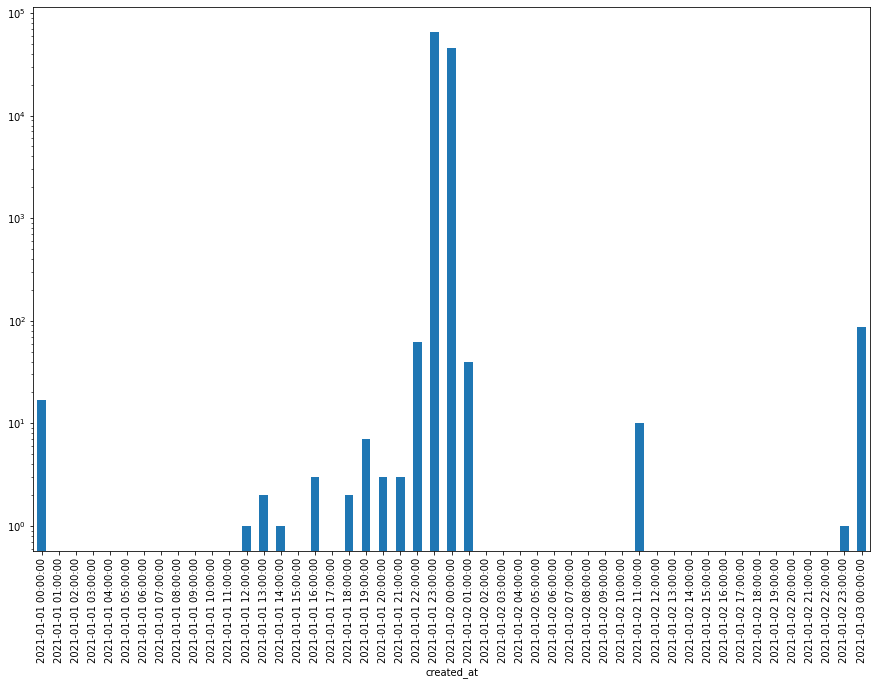

In [232]:
fig, ax = plt.subplots()
df.set_index('created_at', drop=False).groupby(pd.Grouper(key = 'created_at', freq = 'h'))["created_at"].count().plot(ax=ax,kind='bar',figsize=(15,10))
ax.set_yscale('log')

In [233]:
t_start=datetime.datetime.strptime("2021-01-01 23:00:00", '%Y-%m-%d %H:%M:%S')
t_end=datetime.datetime.strptime("2021-01-02 01:00:00", '%Y-%m-%d %H:%M:%S')
df.drop(df[(df['created_at']<t_start) | (df['created_at']>t_end)].index, inplace=True)

In [145]:
df.shape

(110845, 8)

In [235]:
# getting queries that only contain information about users' click_post actions 
# and no information about load_post_page action 
def get_no_loads(x):
    return x[x['action']=='load_post_page'].shape[0] == 0 
no_load_action = df.groupby('source_event_id').apply(lambda x: get_no_loads(x))
no_load_action.dropna(inplace=True)

no_load_queries = df[df['source_event_id'].isin(no_load_action[no_load_action==True].index)]
no_load_queries.shape[0]/df.shape[0]

0.3024583878388741

In [ ]:
# getting queries that don't have information about users' actions in first pages 
# (it can start from first page up to more pages) 
def get_incomplete_load_data(x):
    return x.loc[(x['action']=='load_post_page'), 'post_page_offset'].min() > 0
incomplete_load_data = df.groupby('source_event_id').apply(lambda x: get_incomplete_load_data(x))
incomplete_load_data.dropna(inplace=True)
incomplete_queries = df[df['source_event_id'].isin(incomplete_load_data[incomplete_load_data==True].index)]
incomplete_queries.shape[0]/df.shape[0]

Question 2

In [236]:
# dark query percent
def get_token_len(token):
    if token != "[]":
        token = token.replace("[", "['")
        token = token.replace("]", "']")
        token = token.replace(", ", "','")
    return len(eval(token))

df['tokens_len'] = df['tokens'].dropna().apply(lambda x:get_token_len(x))
dark_query = df[(df['action']=='load_post_page') & (df['post_page_offset']==0) & (df['tokens_len']<10)]
all_query = df[(df['action']=='load_post_page') & (df['post_page_offset']==0)]
dark_query.shape[0]/all_query.shape[0]

0.131482509716824

In [150]:
# query bounce rate
def check_bounce(x):
    return x[x['action']=='click_post'].shape[0] == 0
bounce = df.groupby('source_event_id').apply(lambda x: check_bounce(x))
bounce.sum()/bounce.shape[0]

0.2416409103680809

Question 3

In [237]:
# first metric: the ratio of number of query-clicks to number of tokens  
def get_clicks(x):
    return x[x['action']=='click_post'].shape[0]
query_clicks = df.groupby('source_event_id').apply(lambda x: get_clicks(x))
tokens_num = df.groupby('source_event_id').aggregate(np.sum)['tokens_len']

             clicks  tokens_num
clicks      1.00000     0.34212
tokens_num  0.34212     1.00000


<AxesSubplot:xlabel='clicks', ylabel='tokens_num'>

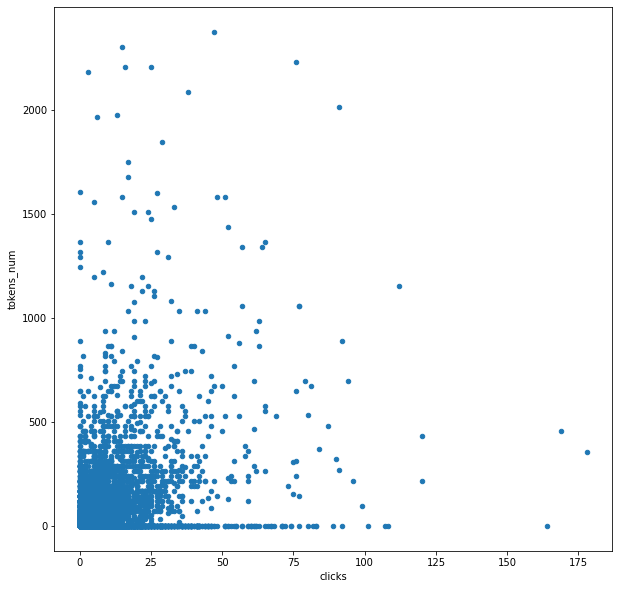

In [238]:
df_click_token = pd.concat([query_clicks, tokens_num], axis=1, keys=['clicks', 'tokens_num'])
print(df_click_token.corr())
df_click_token.plot(kind='scatter', x='clicks', y='tokens_num', figsize=(10,10))

count    9331.000000
mean        0.094887
std         0.202641
min         0.000000
25%         0.000000
50%         0.031250
75%         0.095536
max         3.500000
dtype: float64


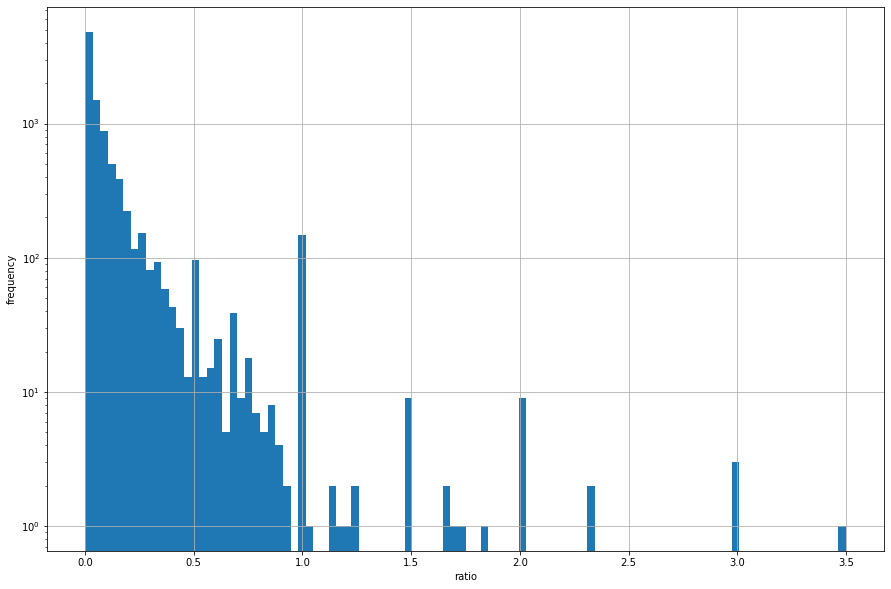

In [241]:
tokens_num.drop(tokens_num[tokens_num==0].index,inplace=True)
query_clicks.drop(tokens_num[tokens_num==0].index,inplace=True)

fig, ax = plt.subplots()
query_click_ratio=(query_clicks/tokens_num)
query_click_ratio.hist(ax=ax,bins=100,figsize=(15,10))
ax.set_yscale('log')
plt.ylabel('frequency')
plt.xlabel('ratio')
print(query_click_ratio.describe())

In [175]:
# second metric: first click rate
# get first click by searching through date and find minimum date recorded for this query
def get_first_click_index(x):
    clicks=x[x['action']=='click_post']
    if clicks.shape[0]<=0:
        return None
    first_click = clicks['created_at'].idxmin()
    return x.loc[first_click, 'post_index_in_post_list']
first_clicks = df.groupby('source_event_id').apply(lambda x: get_first_click_index(x))
first_clicks.dropna(inplace=True)
first_clicks

source_event_id
00142c59-745c-4004-a955-698ddcf1faa6      7.0
0016f59f-9fb3-4ab5-ae78-9783314b81fc      2.0
0017b9ef-5903-40f9-a219-85728eb78436      5.0
0017c208-e016-4231-a022-598ba020f1ff      2.0
00240c5c-9d06-4fcd-93f5-93b842fdab63      1.0
                                        ...  
ffdd48fc-4c05-4c75-bf8c-5cd42729d2b8      5.0
ffe3a1f8-c363-4fbb-af5f-0d244b21aea4     21.0
ffec4e11-c0a1-4fa4-8613-0979d6f46918    100.0
ffef31ea-cb4e-4d00-98ca-118df330cdca      3.0
ffef6048-9db0-4244-9750-3b530552f0ec      1.0
Length: 10760, dtype: float64

In [176]:
first_clicks.describe()

count    10760.000000
mean        26.716914
std        117.406612
min          1.000000
25%          2.000000
50%          4.000000
75%         14.000000
max       5032.000000
dtype: float64

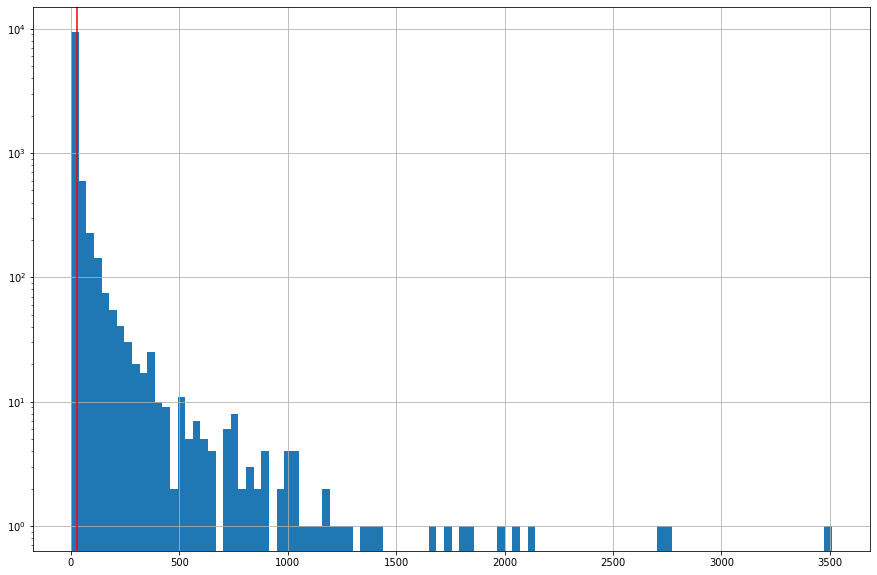

In [228]:
fig, ax = plt.subplots()
first_clicks.hist(ax=ax,bins=100,figsize=(15,10))
ax.set_yscale('log')
plt.axvline(first_clicks.mean(), color='red')

In [222]:
# third metric: mean distance between user's clicks
def get_mean_click_distance(x):
    clicks=x[x['action']=='click_post']
    if clicks.shape[0]==0:
        return 
    return clicks['post_index_in_post_list'].max()/clicks.shape[0]
mean_click_distance = df.groupby('source_event_id').apply(lambda x: get_mean_click_distance(x))

count    10760.000000
mean        15.390170
std         40.939548
min          0.250000
25%          2.800000
50%          6.307072
75%         14.946429
max       1875.500000
dtype: float64


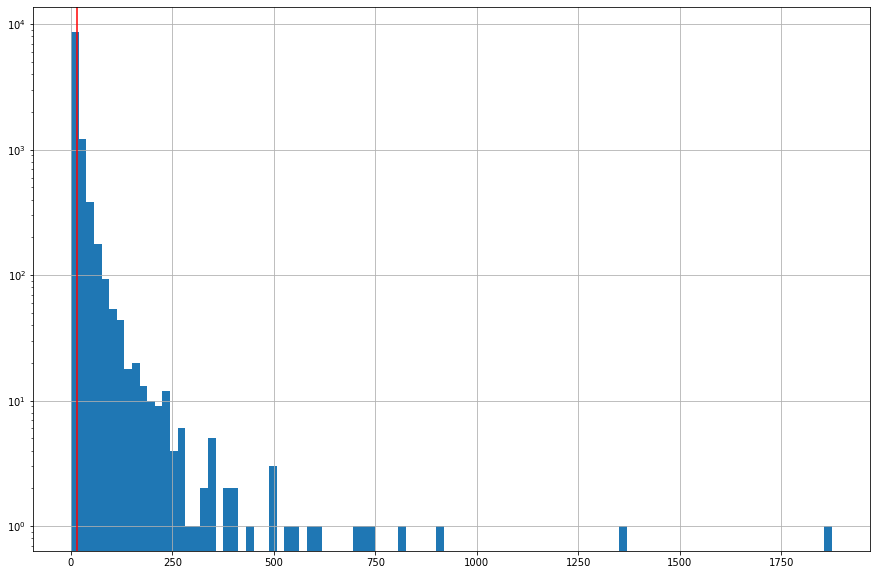

In [223]:
print(mean_click_distance.describe())
fig, ax = plt.subplots()
mean_click_distance.hist(ax=ax,bins=100,figsize=(15,10))
ax.set_yscale('log')
plt.axvline(mean_click_distance.mean(), color='red')

<AxesSubplot:xlabel='first click', ylabel='click distance'>

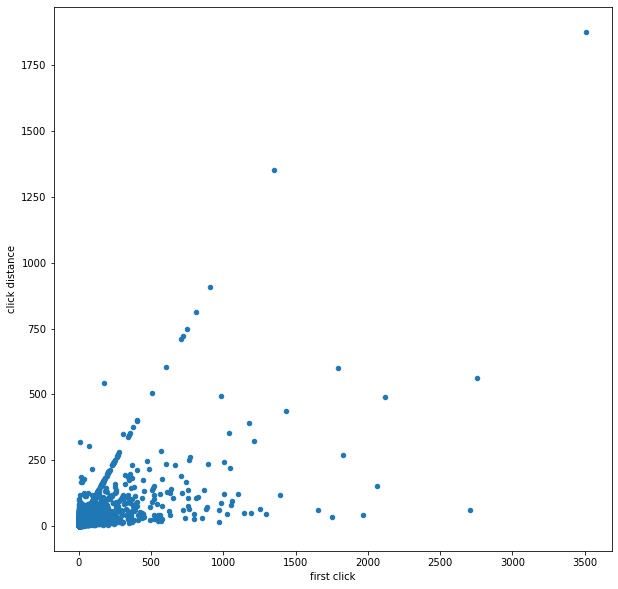

In [193]:
df_click_distance = pd.concat([first_clicks, mean_click_distance], axis=1, keys=['first click', 'click distance'])
df_click_distance.plot(kind='scatter', x='first click', y='click distance', figsize=(10,10))

5025


<AxesSubplot:>

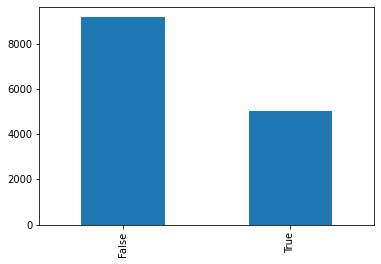

In [214]:
# fourth metric: whether clicks on the three first posts or not
def get_top_3(x):
    return x.loc[x['action']=='click_post', 'post_index_in_post_list'].min() < 4
top_3_click = df.groupby('source_event_id').apply(lambda x: get_top_3(x))
print(top_3_clicks.sum())
top_3_click.value_counts().plot(kind='bar')

In [216]:
top_3_click.mean()

0.3538732394366197

Question 4

<AxesSubplot:>

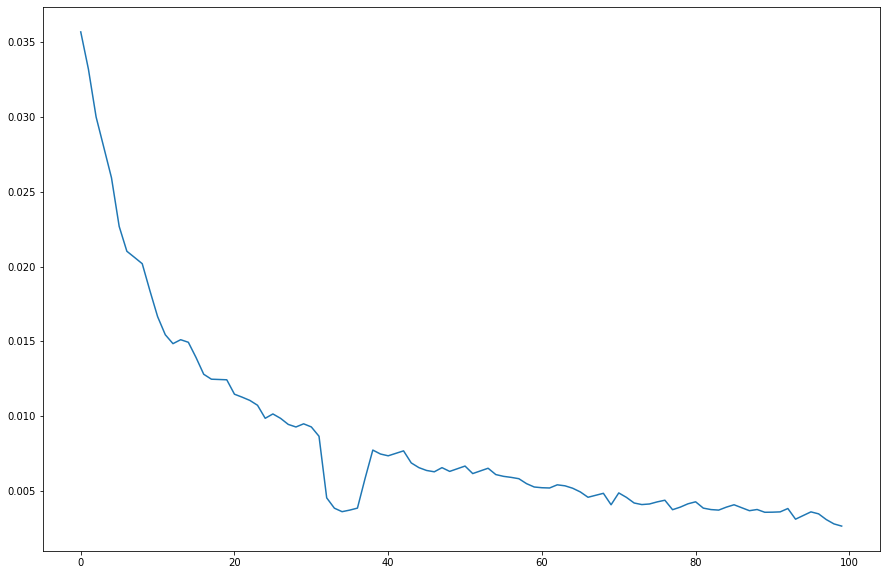

In [243]:
# plot the probability of clicks on a certain post index
click_index_prob=(df['post_index_in_post_list'].value_counts()/df['post_index_in_post_list'].dropna().shape[0])
click_index_prob = click_index_prob.reindex(click_index_prob.index.union(np.linspace(click_index_prob.index.min(),click_index_prob.index.max(), click_index_prob.index.shape[0]))).reset_index(drop=True)  # insert 10 "empty" points between existing ones
click_index_prob = click_index_prob.interpolate('pchip', order=2)  # fill the gaps with values
click_index_prob[range(100)].plot(figsize=(15,10))  # draw new Dataframe

y = 0.30542 / x + 8.16083


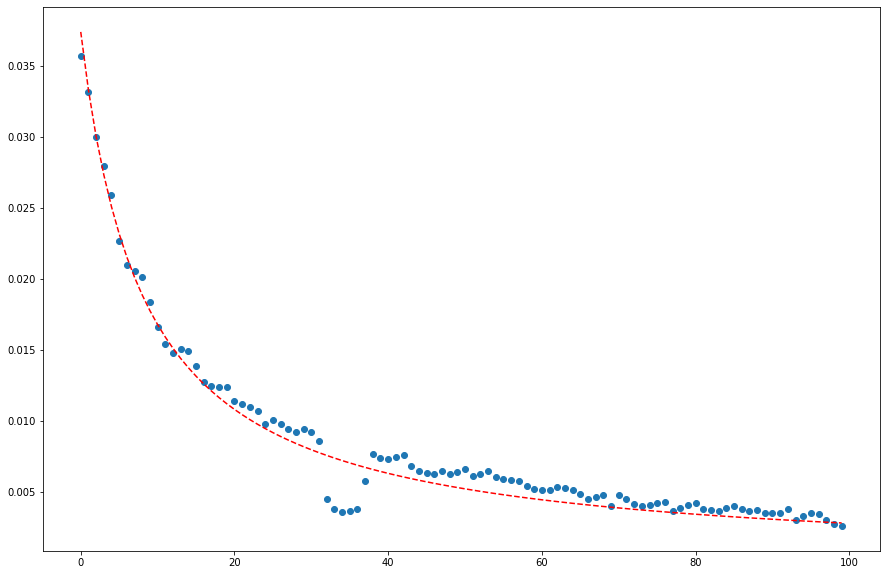

In [245]:
# fit a curve to above distribution
def objective(x, a, b):
    return a/(x+b)
# choose the input and output variables
x, y = click_index_prob.index.values, click_index_prob.values
# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b = popt
print('y = %.5f / x + %.5f' % (a, b))
plt.figure(figsize=(15,10))
pyplot.scatter(x[:100], y[:100])
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b)
pyplot.plot(x_line[:100], y_line[:100], '--', color='red')
pyplot.show()


In [246]:
# probability functions of other metrics based on above information 
def click_prob_by_pos(n,a):
    return a/(n+b)
def first_click_prob_by_pos(n,a):
    prob=1
    for i in range(n-1):
        prob*=1-click_prob_by_pos(i,a)
    prob*=click_prob_by_pos(n,a)
    return prob
first_click_prob_by_pos(1,a)
def top3_clicked_prob(a):
    prob=0
    for i in range(4):
        prob+=first_click_prob_by_pos(i,a)
    return prob